In [127]:
import os, sys
import gymnasium as gym
import time
import numpy as np 
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import plot_policy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from scipy.stats import sem
import text_flappy_bird_gym




In [128]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
rand_generator = np.random.RandomState(42)
agent_info = {"epsilon": 0.1, "discount": 0.99, "lambd":0.9, "step_size":0.2, "episodes":100000, "max_steps":500}

#### Custom argmax function with random tie-breaking ####

In [129]:
def argmax(q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return rand_generator.choice(ties)


def epsilon_greedy_action(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(env.action_space.n)
    else:
        return argmax(Q[state])

### Monte-Carlo agent implementation ###

In [130]:
def monte_carlo_agent(env, agent_info):

    episodes = agent_info["episodes"]
    max_steps = agent_info["max_steps"]
    epsilon = agent_info["epsilon"]
    gamma = agent_info["discount"]

    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    action_space_n = env.action_space.n

    Q = defaultdict(lambda: np.zeros(action_space_n))
    returns_sum = defaultdict(lambda: np.zeros(action_space_n))
    returns_count = defaultdict(lambda: np.zeros(action_space_n))

    moving_avg = 0
    moving_avg_list = []  
    accumumated_rewards = []  
    rewards_list = []

    for episode in range(episodes):
        episode_states = []
        episode_actions = []
        episode_rewards = []
        state = env.reset()[0]

        for t in range(max_steps):

            action = epsilon_greedy_action(Q, state, epsilon)
            
            next_state, reward, done, _, _ = env.step(action)

            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            
            if done:
                break

            state = next_state
            
        score = np.sum(episode_rewards)
        moving_avg = 0.99*moving_avg + 0.01*score

        rewards_list.append(score)
        accumumated_rewards.append(np.sum(rewards_list))
        moving_avg_list.append(moving_avg)
        G = 0
        for t in range(len(episode_states) - 2, -1, -1):
            G = gamma * G + episode_rewards[t+1]
            state_action = episode_states[t] + (episode_actions[t],)
            if state_action not in [episode_states[i] + (episode_actions[i],) for i in range(t)]:
                returns_sum[episode_states[t]][episode_actions[t]] += G
                returns_count[episode_states[t]][episode_actions[t]] += 1
                Q[episode_states[t]][episode_actions[t]] = returns_sum[episode_states[t]][episode_actions[t]] / returns_count[episode_states[t]][episode_actions[t]]

    return Q, moving_avg_list, accumumated_rewards, rewards_list

Q_monte_carlo, moving_avg_mc, cumulative_rew_mc, rewards_list_mc = monte_carlo_agent(env, agent_info)

### Sarsa Lambda agent implementation ###

In [131]:
def sarsa_lambda_agent(env, agent_info):

    episodes = agent_info["episodes"]
    max_steps = agent_info["max_steps"]
    epsilon = agent_info["epsilon"]
    gamma = agent_info["discount"]
    alpha = agent_info["step_size"]
    lambd = agent_info["lambd"]
    
    action_space_n = env.action_space.n
    observation_space_n = (env.observation_space[0].n, env.observation_space[1].n + 2)

    Q = np.array(np.zeros(observation_space_n + (action_space_n,)))
    eligibility_trace = np.array(np.zeros(observation_space_n + (action_space_n,)))
    
    moving_avg = 0
    moving_avg_list = []
    rewards_list = []
    accumumated_rewards = []


    for episode in range(episodes):
        episode_rewards = []
        state = env.reset()[0]
        action = epsilon_greedy_action(Q, state, epsilon)
        for t in range(max_steps):
            next_state, reward, done, _, _ = env.step(action)
            next_action = epsilon_greedy_action(Q, next_state, epsilon)

            q_next = 0 if done else Q[next_state][next_action]
            q = Q[state][action]

            delta = reward + gamma * q_next - q
            eligibility_trace[state][action] += 1

            Q[:,:] += alpha * delta * eligibility_trace[:,:]
            eligibility_trace[:,:] *= gamma * lambd
                
            episode_rewards.append(reward)
            if done:
                break
            state = next_state
            action = next_action
        
        
        score = np.sum(episode_rewards)
        moving_avg = 0.99*moving_avg + 0.01*score

        rewards_list.append(score)
        accumumated_rewards.append(np.sum(rewards_list))
        moving_avg_list.append(moving_avg)

    return Q, moving_avg_list, accumumated_rewards, rewards_list


Q_sarsa_lambda, moving_avg_sarsa, cumulative_rew_sarsa, rewards_list_sarsa = sarsa_lambda_agent(env, agent_info)
Q_sarsa_lambda = {(x, y): Q_sarsa_lambda[(x, y)] for x in range(13) for y in range(-12, 12)}

### Agents performance comparison ###

The function down below allows to plot the moving average reward and the cumulative reward of both agents in order to compare them

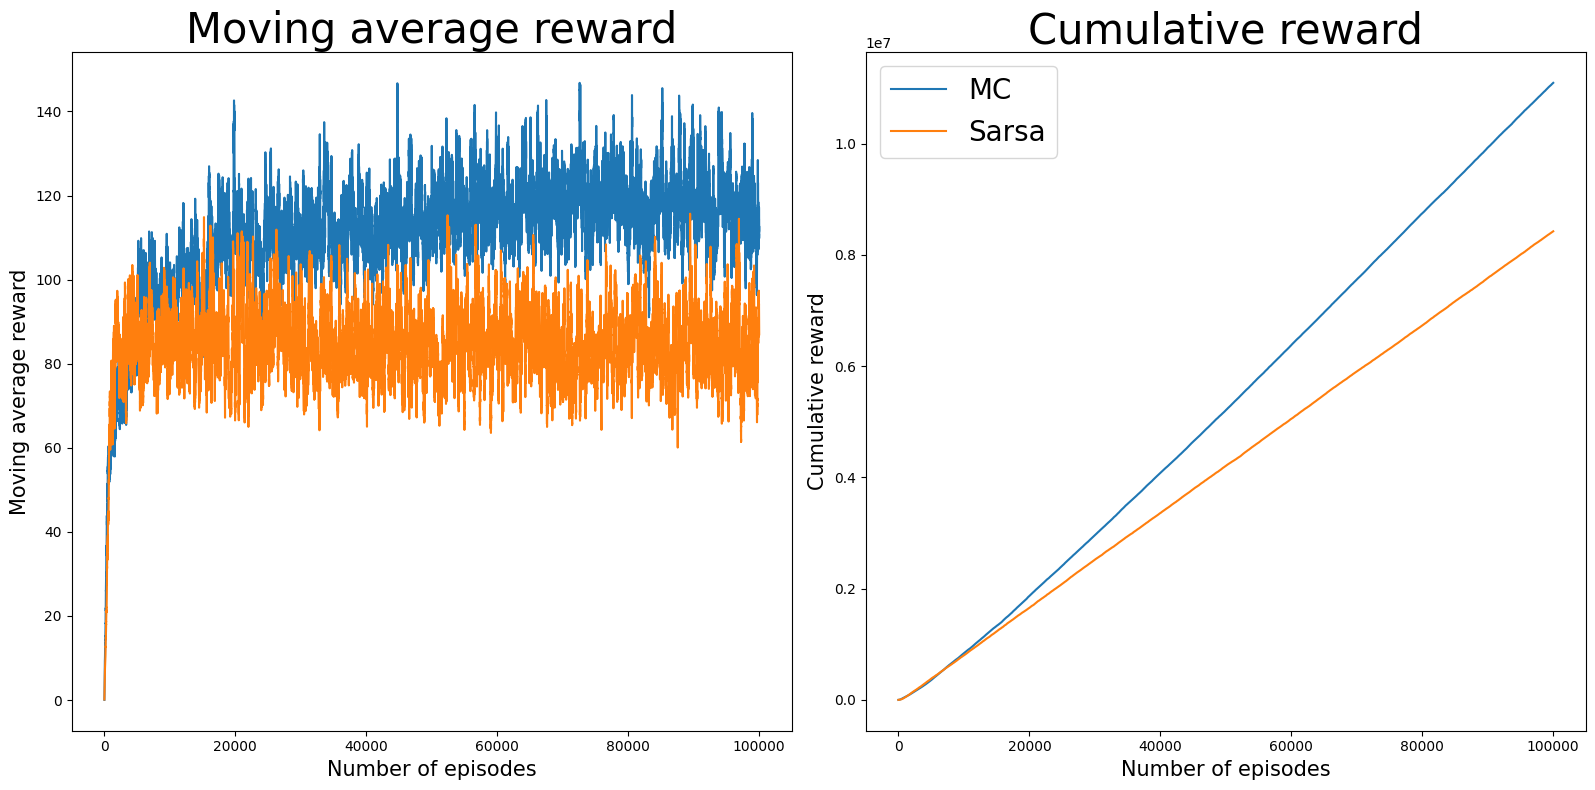

In [132]:
def compare_agents_performance(moving_avgs, cumulative_rews):

    num_episodes = len(moving_avgs[0])

    range_episodes = np.arange(num_episodes)

    # Tracé des graphiques
    plt.figure(figsize=(24, 8))

    plt.subplot(1, 3, 1)
    for i, algorithm in enumerate(["MC", "Sarsa"]):
        plt.plot(range_episodes, moving_avgs[i], label=algorithm)
    plt.title('Moving average reward', fontsize=30)
    plt.xlabel('Number of episodes', fontsize=15)
    plt.ylabel('Moving average reward', fontsize=15)

    plt.subplot(1, 3, 2)
    for i, algorithm in enumerate(["MC", "Sarsa"]):
        plt.plot(range_episodes, cumulative_rews[i], label=algorithm)
    plt.title('Cumulative reward', fontsize=30)
    plt.xlabel('Number of episodes', fontsize=15)
    plt.ylabel('Cumulative reward', fontsize=15)

    plt.tight_layout()
    plt.legend(prop={'size': 20})
    plt.show()

compare_agents_performance([moving_avg_mc, moving_avg_sarsa], [cumulative_rew_mc, cumulative_rew_sarsa])

### Policy plot ###

The function down below allows to plot the computed optimal policy for a given agent

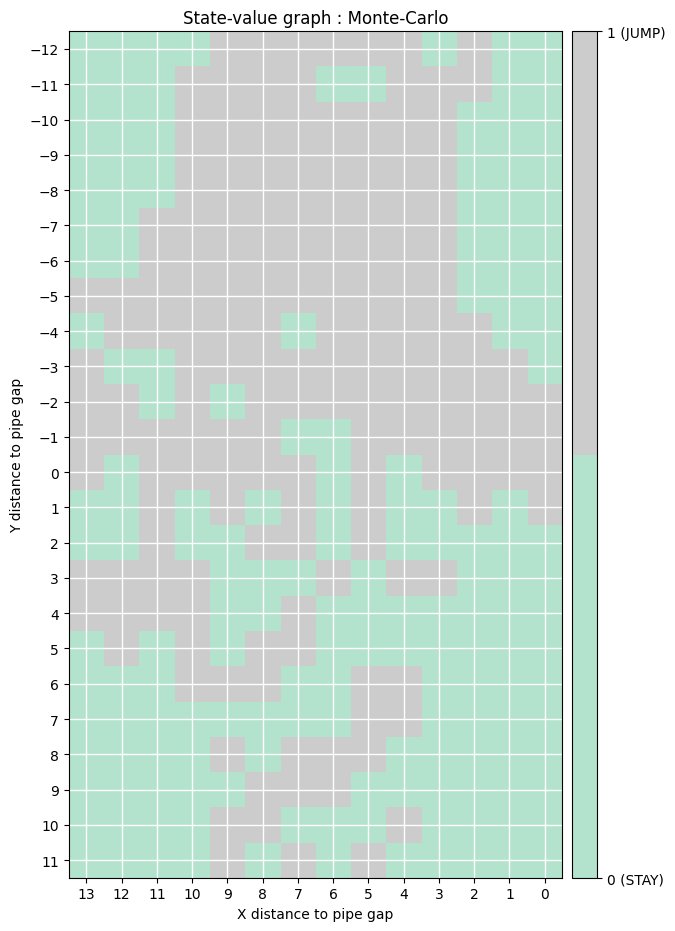

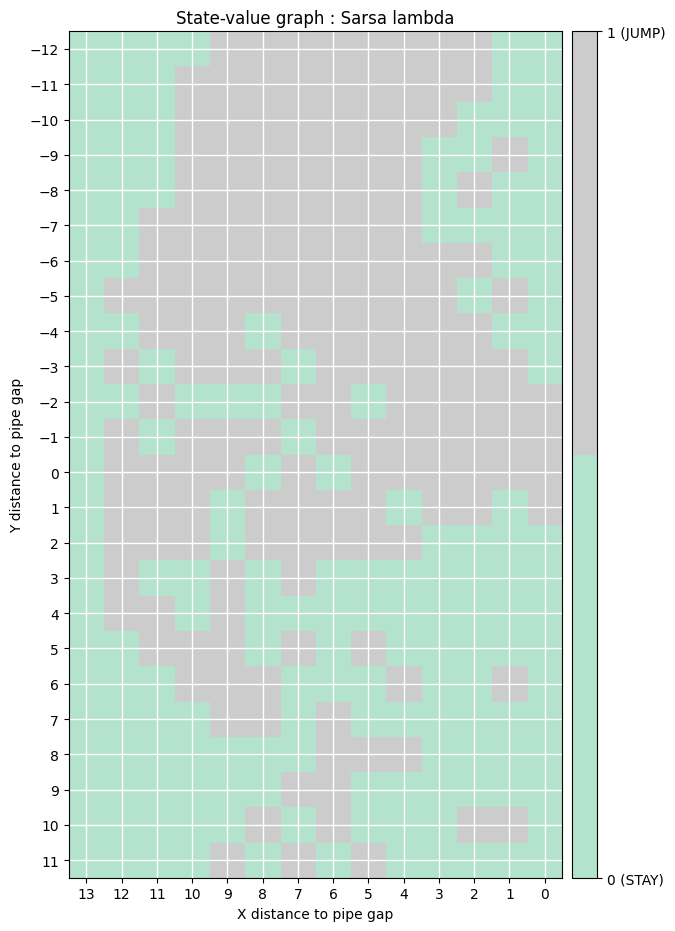

In [133]:
def plot_policy(Q, label):

    def get_Z(x, y):
        if (x,y) in Q:
            return 0 if Q[x,y][0] == Q[x,y][1] else np.argmax(Q[x,y])
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(13, -1, -1)
        y_range = np.arange(-12, 12)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[13.5,-0.5, -12.5, 11.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('X distance to pipe gap')
        ax.set_ylabel('Y distance to pipe gap')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STAY)','1 (JUMP)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(122)
    ax.set_title(f'State-value graph : {label}')
    get_figure(ax)
    plt.show()



plot_policy(Q_monte_carlo, "Monte-Carlo")
plot_policy(Q_sarsa_lambda, "Sarsa lambda")

### State-Value function plot ###

The function down below allows to plot the State-Value function for a given agent

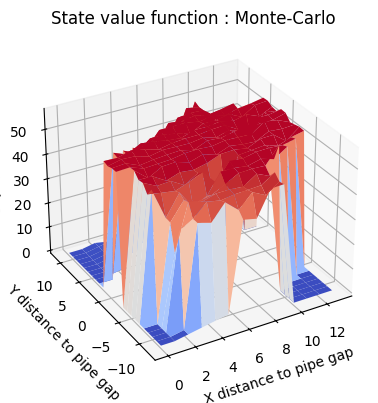

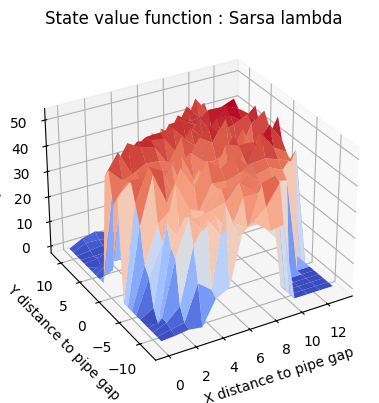

In [134]:
def plot_state_values(Q, label):
    V = dict((k,np.max(v)) for k, v in Q.items())
    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(13, -1, -1)
        y_range = np.arange(-12, 12)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=0, vmax=50)
        ax.set_xlabel('X distance to pipe gap')
        ax.set_ylabel('Y distance to pipe gap')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title(f'State value function : {label}')
    get_figure(ax)

    plt.show()

plot_state_values(Q_monte_carlo, "Monte-Carlo")
plot_state_values(Q_sarsa_lambda, "Sarsa lambda")

### Parameters variation plot ###

The function provided below plots the total sum of rewards per episode for a specified agent over a range of parameters.

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:24<00:00, 24.10s/it]


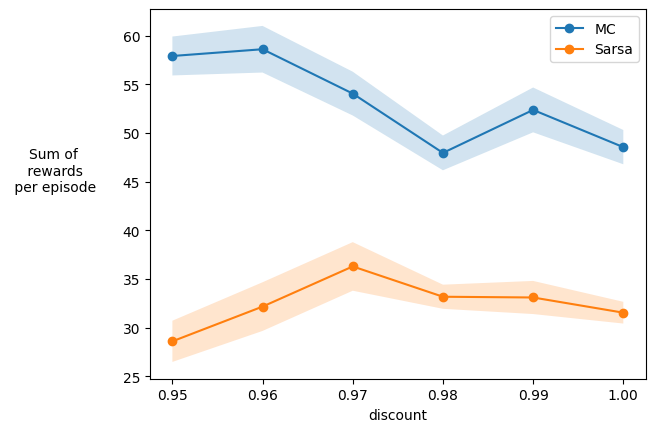

100%|██████████| 7/7 [02:12<00:00, 18.94s/it]


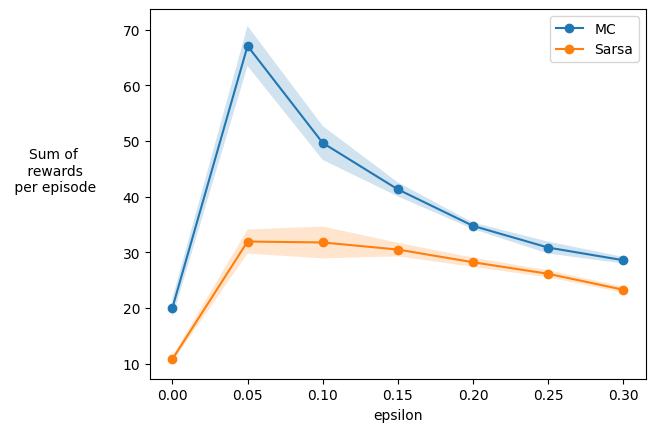

In [135]:
def agent_parameters_variation(param_name, param_range):
    all_reward_sums = {}
    agent_info = {"epsilon": 0.1, "discount": 0.99, "lambd":0.9, "step_size":0.2, "episodes":1000, "max_steps":500}
    num_runs = 10
    all_reward_sums = {}

    for algorithm in ["MC", "Sarsa"]:
        for param in tqdm(param_range):
            all_reward_sums[(algorithm, param)] = []
            agent_info[param_name] = param
            for run in tqdm(range(num_runs)):
                agent_info["seed"] = run
                env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
                _, _, _, reward_list = monte_carlo_agent(env, agent_info) if algorithm == "MC" else sarsa_lambda_agent(env, agent_info)
                all_reward_sums[(algorithm, param)].append(np.mean(reward_list))
            

    for algorithm in ["MC", "Sarsa"]:
        algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, param)]) for param in param_range])
        algorithm_stds = np.array([sem(all_reward_sums[(algorithm, param)]) for param in param_range])
        plt.plot(param_range, algorithm_means, marker='o', linestyle='solid', label=algorithm)
        plt.fill_between(param_range, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

    plt.legend()
    plt.xlabel(param_name)
    plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
    plt.xticks(param_range)
    plt.show()


agent_parameters_variation("discount", np.linspace(0.95, 1, 6))
agent_parameters_variation("epsilon", np.linspace(0, 0.3, 7))

### Environnement parameters variation plot ###

The function provided below plots the Reward mean score of both agents on a range of environment parameters

C:\Users\louis\AppData\Local\Temp\ipykernel_9492\4263768781.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.axhline(y=reward_score_pipe_gap[int(np.where(np.array(pipe_gap_range) == default_pipe_gap)[0])], color='r', linestyle='--')
C:\Users\louis\AppData\Local\Temp\ipykernel_9492\4263768781.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.axhline(y=reward_score_height[int(np.where(np.array(height_range) == default_height)[0])], color='r', linestyle='--')
C:\Users\louis\AppData\Local\Temp\ipykernel_9492\4263768781.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in f

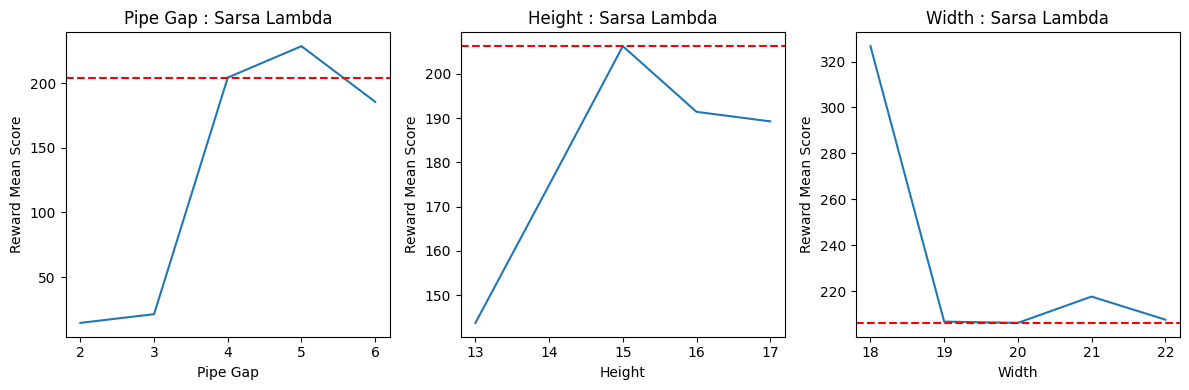

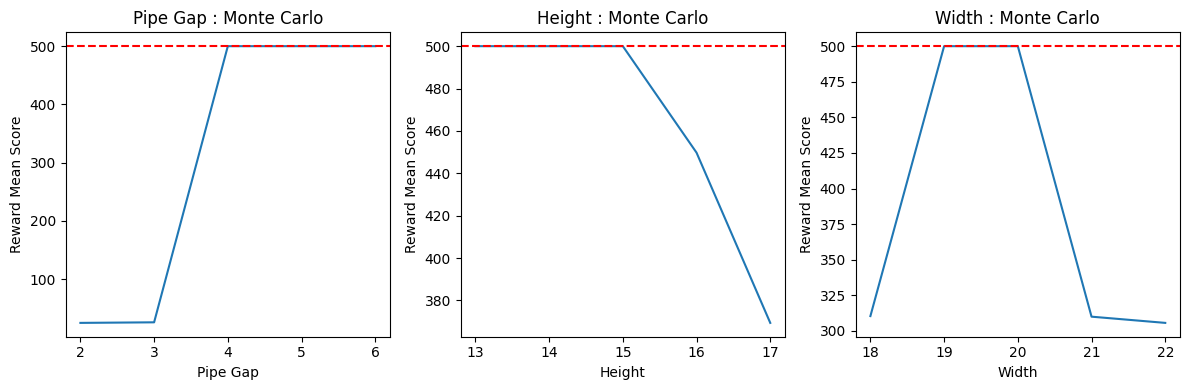

In [136]:
def action_choice(Q, state):
    if (state not in Q) or (state[0] > 13) or ((state[1] > 11) or (state[1] < -12)):
        return np.random.randint(env.action_space.n)
    else:
        return argmax(Q[state])

def try_policy_with_different_env_parameters(Q, height, width, pipe_gap, max_steps, nb_runs):
    env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)
    rewards_per_episode = []
    for run in range(nb_runs):
        reward_sum = 0
        state = env.reset()[0]
        for t in range(max_steps):
            action = action_choice(Q, state)
            state, reward, done, _, _ = env.step(action)
            reward_sum += reward
            if done:
                break
        rewards_per_episode.append(reward_sum)
    return np.mean(rewards_per_episode)

def plot_different_params_performance(Q,max_steps, nb_runs, label):
    default_pipe_gap = 4
    default_height = 15
    default_width = 20

    reward_score_pipe_gap = []
    reward_score_height = []
    reward_score_width = []

    pipe_gap_range = range(2,7)
    height_range = range(13,18)
    width_range = range(18,23)

    for pipe_gap in pipe_gap_range:
        reward_score = try_policy_with_different_env_parameters(Q, default_height, default_width, pipe_gap, max_steps, nb_runs)
        reward_score_pipe_gap.append(reward_score)
    
    for height in height_range:
        reward_score = try_policy_with_different_env_parameters(Q, height, default_width, default_pipe_gap, max_steps, nb_runs)
        reward_score_height.append(reward_score)

    for width in width_range:
        reward_score = try_policy_with_different_env_parameters(Q, default_height, width, default_pipe_gap, max_steps, nb_runs)
        reward_score_width.append(reward_score)

    # Tracé des graphiques
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(pipe_gap_range, reward_score_pipe_gap)
    plt.axhline(y=reward_score_pipe_gap[int(np.where(np.array(pipe_gap_range) == default_pipe_gap)[0])], color='r', linestyle='--')
    plt.title(f'Pipe Gap : {label}')
    plt.xlabel('Pipe Gap')
    plt.ylabel('Reward Mean Score')

    plt.subplot(1, 3, 2)
    plt.plot(height_range, reward_score_height)
    plt.axhline(y=reward_score_height[int(np.where(np.array(height_range) == default_height)[0])], color='r', linestyle='--')
    plt.title(f'Height : {label}')
    plt.xlabel('Height')
    plt.ylabel('Reward Mean Score')

    plt.subplot(1, 3, 3)
    plt.plot(width_range, reward_score_width)
    plt.axhline(y=reward_score_width[int(np.where(np.array(width_range) == default_width)[0])], color='r', linestyle='--')
    plt.title(f'Width : {label}')
    plt.xlabel('Width')
    plt.ylabel('Reward Mean Score')

    plt.tight_layout()
    plt.show()



plot_different_params_performance(Q_sarsa_lambda, 500, 1000, "Sarsa Lambda")
plot_different_params_performance(Q_monte_carlo, 500, 1000, "Monte Carlo")